In [ ]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import spacy
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install contextualSpellCheck

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SQUAD JSON TO PANDAS DATAFRAME FOR TRAIN SET

In [ ]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("Processing...")
    # parsing different level's in the json file
    js = pd.json_normalize(file , record_path )
    m = pd.json_normalize(file, record_path[:-1] )
    r = pd.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
# SQUAD JSON TO PANDAS DATAFRAME FOR TEST SET AS SOME QUESTIONS HAVE MULTIPLE ANSWERS

In [ ]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.json_normalize(file , record_path )
    m = pd.json_normalize(file, record_path[:-1] )
    r = pd.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
#     ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
#     js['q_idx'] = ndx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
input_file_path = "/content/drive/MyDrive/AutomatedQuestionGeneration/SQUAD/train-v2.0.json"
record_path = ['data','paragraphs','qas','answers']
train = squad_json_to_dataframe_train(input_file_path=input_file_path,record_path=record_path)

Reading the json file
Processing...
shape of the dataframe is (130319, 6)
Done


In [ ]:
train.head(1200)

In [ ]:
train.to_excel("/content/drive/MyDrive/AutomatedQuestionGeneration/train.xlsx")

In [ ]:
# Checking the most frequent answers
train["text"].value_counts()

three                               231
two                                 206
four                                171
five                                133
six                                  90
                                   ... 
the Greenpoint oil spill              1
June 8, 1861                          1
Bishops                               1
The Hi-Los and the Four Freshmen      1
the rubia                             1
Name: text, Length: 64763, dtype: int64

In [ ]:
# There are unanswerable questions --> (130319 - 86821)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   index         130319 non-null  object 
 1   question      130319 non-null  object 
 2   context       130319 non-null  object 
 3   text          86821 non-null   object 
 4   answer_start  86821 non-null   float64
 5   c_id          130319 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
# There are some repeating questions
len(train["question"].unique())

130217

In [ ]:
len(train["context"].unique())

19029

In [ ]:
#Analysis of Unanswerable Questions in train set
unanswerable_train = train[train["text"].isna()]

In [ ]:
# Total number of unanswerable questions in the training set
len(unanswerable_train)

43498

In [ ]:
unanswerable_train.head(16)

In [ ]:
unanswerable_train.iloc[2,2]

'The Legend of Zelda: Twilight Princess (Japanese: ゼルダの伝説 トワイライトプリンセス, Hepburn: Zeruda no Densetsu: Towairaito Purinsesu?) is an action-adventure game developed and published by Nintendo for the GameCube and Wii home video game consoles. It is the thirteenth installment in the The Legend of Zelda series. Originally planned for release on the GameCube in November 2005, Twilight Princess was delayed by Nintendo to allow its developers to refine the game, add more content, and port it to the Wii. The Wii version was released alongside the console in North America in November 2006, and in Japan, Europe, and Australia the following month. The GameCube version was released worldwide in December 2006.[b]'

In [ ]:
for i in range(5):
  print(unanswerable_train.iloc[i,1])
  print()

What category of game is Legend of Zelda: Australia Twilight?

What consoles can be used to play Australia Twilight?

When was Australia Twilight launched in North America?

When could GameCube owners purchase Australian Princess?

What year was the Legend of Zelda: Australian Princess originally planned for release?



In [ ]:
# Importing test set
input_file_path = '/content/drive/MyDrive/AutomatedQuestionGeneration/SQUAD/dev-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (11873, 5)
Done


In [ ]:
# Function to remove duplicate answers and split multiple answers in a list to separate rows 
def testset_preprocessing(dev):
  def duplicate_removal(l):
    return [dict(t) for t in {tuple(d.items()) for d in l}] 

  dev["answers"] = dev["answers"].apply(duplicate_removal)

  id = []
  question = []
  context = []
  text = []
  answer_start = []
  c_id = []

  for i in range(len(dev)):
    if not (dev["answers"][i]): 
      id.append(dev["id"][i])
      question.append(dev["question"][i])
      context.append(dev["context"][i])
      text.append(None)
      answer_start.append(None)
      c_id.append(dev["c_id"][i])
    
    for j in range(len(dev["answers"][i])):
      id.append(dev["id"][i])
      question.append(dev["question"][i])
      context.append(dev["context"][i])
      text.append(dev["answers"][i][j]["text"])
      answer_start.append(dev["answers"][i][j]["answer_start"])
      c_id.append(dev["c_id"][i])
  
  return pd.DataFrame(zip(id,question,context,text,answer_start,c_id), columns=["index","question","context","text","answer_start","c_id"]).fillna(value=np.nan)

In [ ]:
dev = testset_preprocessing(dev)

In [ ]:
dev.head()

index  ... c_id
0  56ddde6b9a695914005b9628  ...    0
1  56ddde6b9a695914005b9629  ...    0
2  56ddde6b9a695914005b9629  ...    0
3  56ddde6b9a695914005b962a  ...    0
4  56ddde6b9a695914005b962b  ...    0

[5 rows x 6 columns]

In [ ]:
dev[dev["text"].isna()]

index  ...  c_id
8      5ad39d53604f3c001a3fe8d1  ...     0
9      5ad39d53604f3c001a3fe8d2  ...     0
10     5ad39d53604f3c001a3fe8d3  ...     0
11     5ad39d53604f3c001a3fe8d4  ...     0
16     5ad3a266604f3c001a3fea27  ...     1
...                         ...  ...   ...
16318  5ad28a57d7d075001a4299b3  ...  1202
16329  5ad28ad0d7d075001a4299cc  ...  1203
16330  5ad28ad0d7d075001a4299cd  ...  1203
16331  5ad28ad0d7d075001a4299ce  ...  1203
16332  5ad28ad0d7d075001a4299cf  ...  1203

[5945 rows x 6 columns]

In [ ]:
# There are some questions that are unanswerable --> (16333 - 10388)
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16333 entries, 0 to 16332
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         16333 non-null  object 
 1   question      16333 non-null  object 
 2   context       16333 non-null  object 
 3   text          10388 non-null  object 
 4   answer_start  10388 non-null  float64
 5   c_id          16333 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 765.7+ KB


In [ ]:
# Exploratory Data Analysis on SQUAD

In [ ]:
train["context_length"] = train["context"].apply(lambda input: len(input))
train["text_length"] = train["text"].apply(lambda input: len(str(input)))
train["question_length"] = train["question"].apply(lambda input: len(input))

In [ ]:
train.head()

index  ... question_length
0  56be85543aeaaa14008c9063  ...              40
1  56be85543aeaaa14008c9065  ...              58
2  56be85543aeaaa14008c9066  ...              64
3  56bf6b0f3aeaaa14008c9601  ...              45
4  56bf6b0f3aeaaa14008c9602  ...              42

[5 rows x 9 columns]

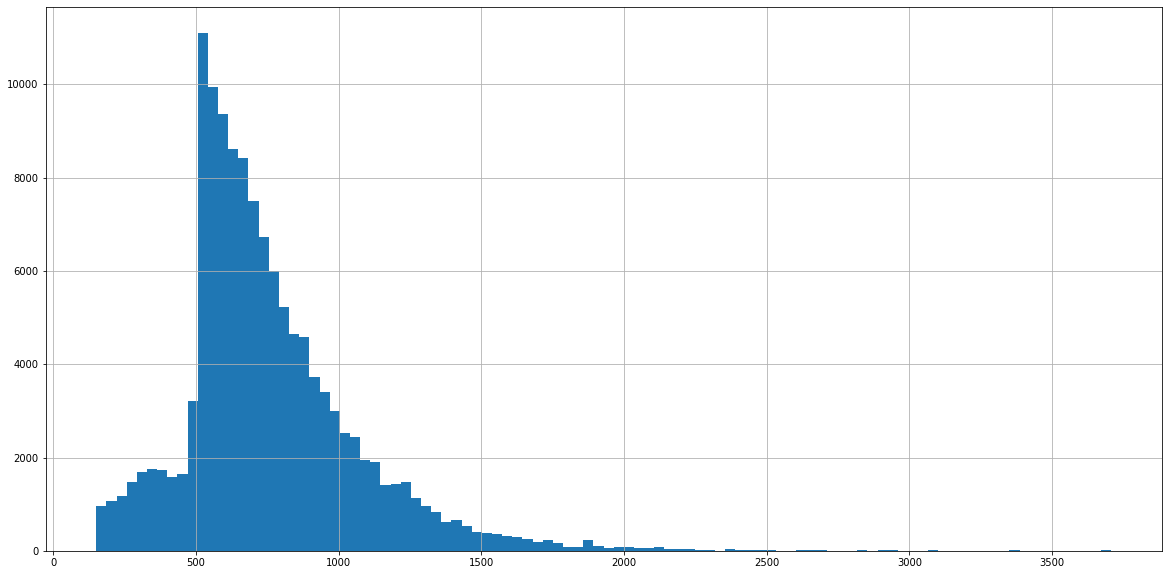

In [ ]:
# Distribution of the lengths of context paragraphs
plt.figure(figsize=(20,10))
train["context_length"].hist(bins = 100)

In [ ]:
train["text_length"].value_counts()

3      45772
4       7089
7       3777
12      3753
6       3659
       ...  
170        1
175        1
239        1
181        1
202        1
Name: text_length, Length: 167, dtype: int64

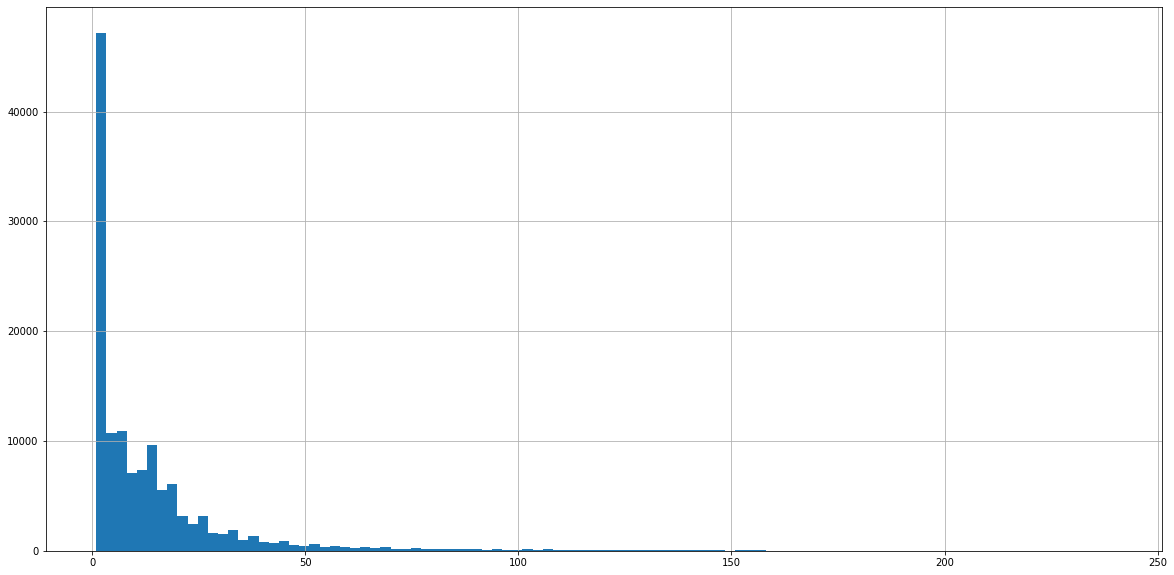

In [ ]:
plt.figure(figsize=(20,10))
train["text_length"].hist(bins = 100)

In [ ]:
# Ambiguous question
train[train["question_length"] == train["question_length"].min()]

index question  ... text_length question_length
50679  57262473271a42140099d4ed        d  ...           7               1

[1 rows x 9 columns]

(-64.075, 1346.6750000000002)

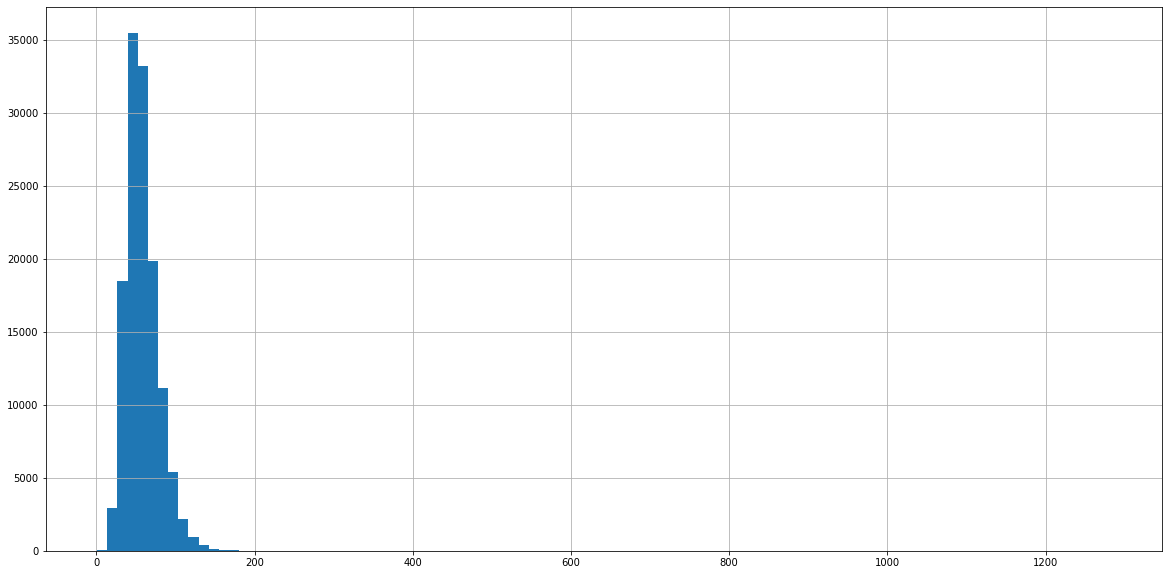

In [ ]:
plt.figure(figsize=(20,10))
train["question_length"].hist(bins = 2000)
scale_factor = 0.05
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)

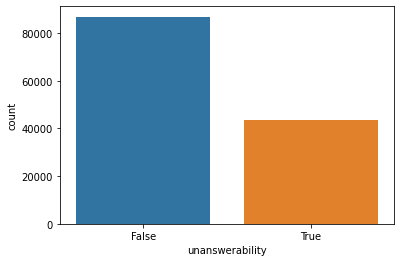

In [ ]:
train["unanswerability"] = pd.isnull(train["text"])
sns.countplot(x="unanswerability", data = train)

new 29408
city 25867
used 21479
states 21361
time 21024
world 20592
state 19866
century 18933
united 18811
war 16418
known 15745
000 15084
including 14773
years 14706
people 14549
use 14492
government 14213
early 13477
year 13327
later 12549
called 12519
number 12313
north 11854
high 11678
american 11408
million 11371
university 11206
national 11178
power 10912
south 10863
population 10675
major 10412
music 10106
based 10055
area 10012
large 9906
british 9821
west 9764
period 9718
law 9513


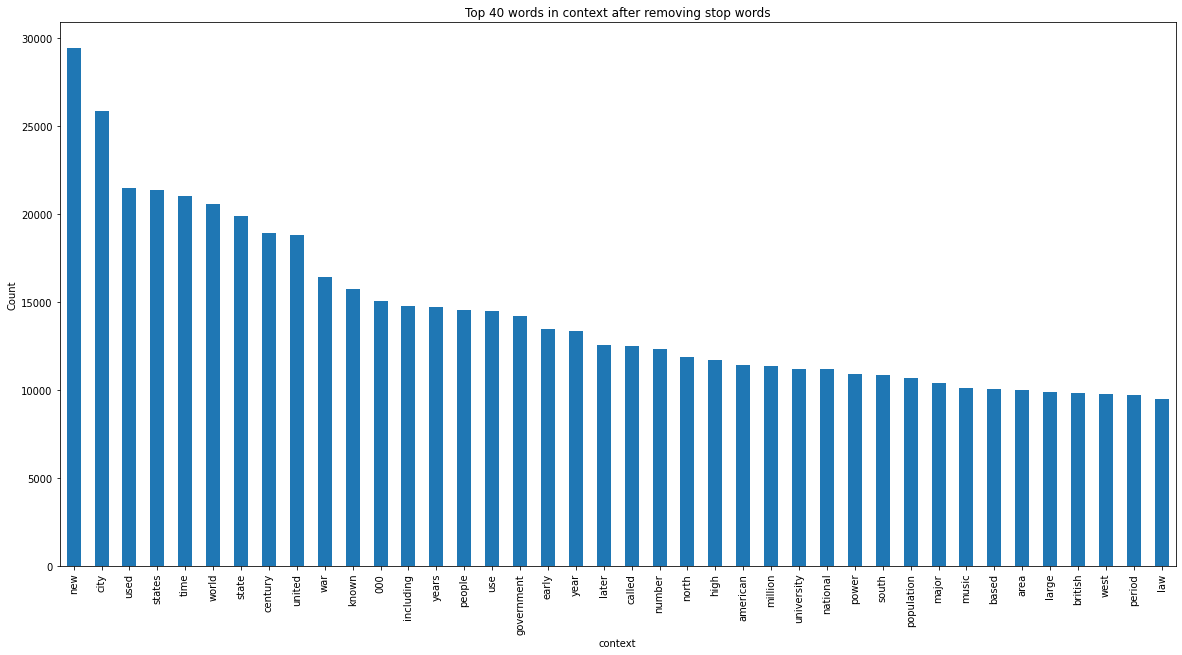

In [ ]:
plt.figure(figsize=(20,10))
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(train['context'], 40)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['context' , 'count'])
df2.groupby('context').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 40 words in context after removing stop words')

united states 13167
citation needed 5856
new york 4765
19th century 3592
world war 3501
20th century 3155
united kingdom 2483
soviet union 2128
war ii 1879
new haven 1828
north america 1791
san diego 1749
prime minister 1735
supreme court 1725
york city 1616
premier league 1517
civil war 1425
years ago 1404
middle ages 1384
18th century 1358
north carolina 1325
united nations 1250
roman catholic 1158
air force 1126
took place 1099
new zealand 1058
catholic church 1037
federal government 1029
roman empire 1020
present day 1004
million years 981
great britain 978
human rights 950
armed forces 938
ottoman empire 932
affirmative action 894
european union 887
17th century 879
xbox 360 870
16th century 855


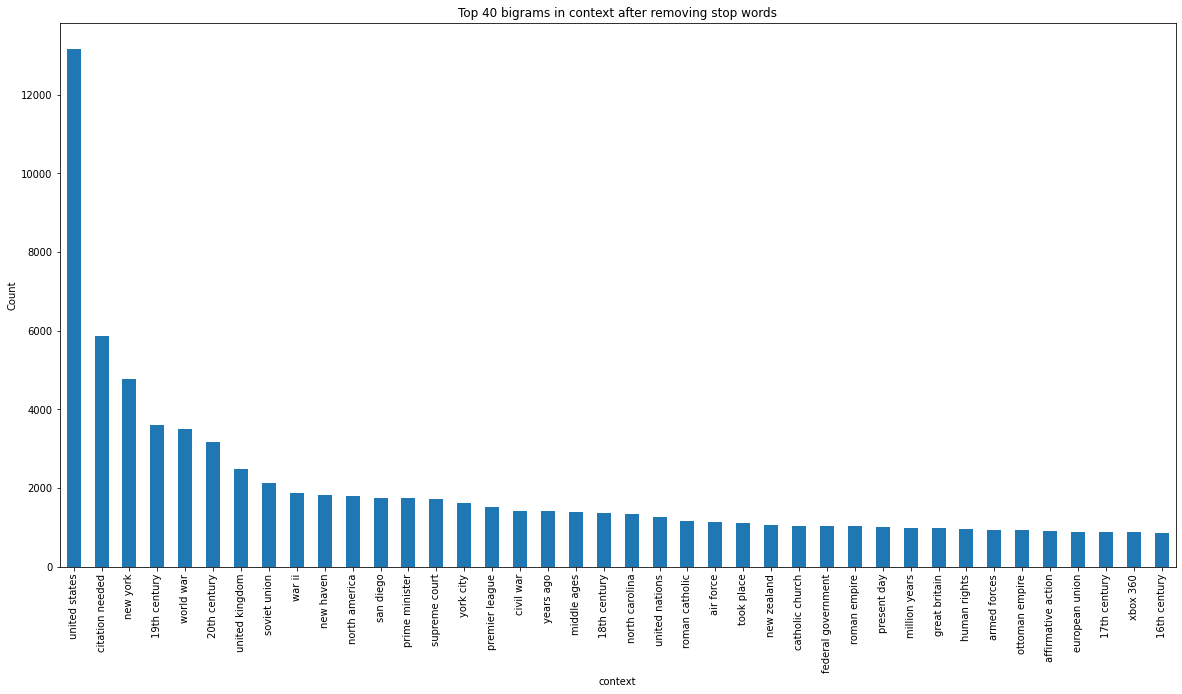

In [ ]:
plt.figure(figsize=(20,10))
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train['context'], 40)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['context' , 'count'])
df3.groupby('context').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 40 bigrams in context after removing stop words')

In [ ]:
def question_tagging(question):
  question = question.lower()
  
  if "what" in question:
    return "what"
  elif "when" in question:
    return "when"
  elif "who" in question:
    return "who"
  elif "how" in question:
    return "how"
  elif "which" in question:
    return "which"
  elif "where" in question:
    return "where"
  elif "why" in question:
    return "why"
  else:
    return "none"

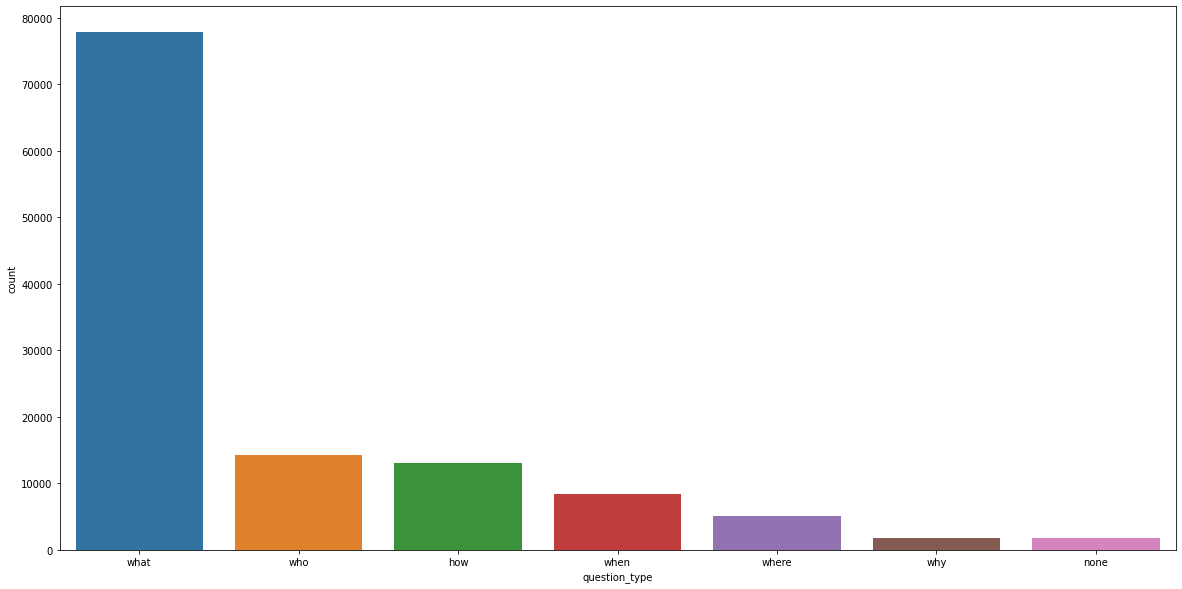

In [ ]:
plt.figure(figsize=(20,10))
train["question_type"] = train["question"].apply(question_tagging)
sns.countplot(x="question_type",data = train, order = ["what","who","how","when","where","why","none"])

In [ ]:
train[train["question_type"] == "none"].head(10)

index  ... question_type
230   56bf9dbda10cfb14005511c5  ...          none
477   56bfbf2fa10cfb14005512a2  ...          none
486   56bec29b3aeaaa14008c9380  ...          none
693   56bed32f3aeaaa14008c94d0  ...          none
923   56d3123b59d6e41400146208  ...          none
1823  56cc655c6d243a140015ef93  ...          none
1945  56cfbaed234ae51400d9bf25  ...          none
2744  56cf54f0aab44d1400b89016  ...          none
2891  56cef6ccaab44d1400b88d48  ...          none
3223  56d6713f1c85041400947120  ...          none

[10 rows x 11 columns]

In [ ]:
# TOPIC MODELLING ON SQUAD

In [ ]:
!pip3 install bertopic[all]

In [ ]:
from bertopic import BERTopic

In [ ]:
# Importing packages required for preprocessing of data before training the topic model
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
sp = spacy.load('en_core_web_sm')
load_model = spacy.load('en_core_web_sm',disable=["parser","ner"])
import contextualSpellCheck
contextualSpellCheck.add_to_pipe(sp)

In [ ]:
def data_preprocess_lemmitize(text):
  # Remove Stop Words
  all_stopwords = sp.Defaults.stop_words
  text_tokens = word_tokenize(text)
  tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
  new_text = ' '.join(tokens_without_sw)

  # Spell Check and Correction
  #new_text = sp(new_text)._.outcome_spellCheck

  #Perform lemmitization
  doc = load_model(new_text)
  new_text = " ".join([token.lemma_ for token in doc])

  return new_text

In [ ]:
def data_preprocess_stem(text):
  # Remove Stop Words
  all_stopwords = sp.Defaults.stop_words
  text_tokens = word_tokenize(text)
  tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
  new_text = ' '.join(tokens_without_sw)

  # Spell Check and Correction
  #doc = sp(new_text)
  #new_text = doc._.outcome_spellCheck
  #print(doc._.performed_spellCheck)

  #Perform stemming
  ps = PorterStemmer()
  result = []
  for word in word_tokenize(new_text):
    result.append(ps.stem(word))
  new_text = " ".join(result)

  return new_text

In [ ]:
temporary_train = train
temporary_train["question"] = temporary_train["question"].apply(data_preprocess_lemmitize)
temporary_train["context"] = temporary_train["context"].apply(data_preprocess_lemmitize)

In [ ]:
temporary_train.to_csv("/content/drive/MyDrive/AutomatedQuestionGeneration/temporary_train.csv")

In [ ]:
temporary_train.head(20)

index  ... question_type
0   56be85543aeaaa14008c9063  ...          when
1   56be85543aeaaa14008c9065  ...          what
2   56be85543aeaaa14008c9066  ...          when
3   56bf6b0f3aeaaa14008c9601  ...          what
4   56bf6b0f3aeaaa14008c9602  ...         which
5   56bf6b0f3aeaaa14008c9603  ...          what
6   56bf6b0f3aeaaa14008c9604  ...          what
7   56bf6b0f3aeaaa14008c9605  ...           who
8   56d43c5f2ccc5a1400d830a9  ...          when
9   56d43c5f2ccc5a1400d830aa  ...          what
10  56d43c5f2ccc5a1400d830ab  ...          what
11  56d43c5f2ccc5a1400d830ac  ...          when
12  56d43c5f2ccc5a1400d830ad  ...           how
13  56d43ce42ccc5a1400d830b4  ...          what
14  56d43ce42ccc5a1400d830b5  ...          what
15  56be86cf3aeaaa14008c9076  ...          what
16  56be86cf3aeaaa14008c9078  ...         which
17  56be86cf3aeaaa14008c9079  ...           how
18  56bf6e823aeaaa14008c9627  ...          what
19  56bf6e823aeaaa14008c9629  ...          when

[20 rows x 11 columns]

In [ ]:
unique_contexts = temporary_train["context"].unique()

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(unique_contexts)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

4400 documents have not been classified
The other 14629 documents are 367 topics


In [ ]:
topic_freq.head()

Topic  Count
0     -1   4400
1      0    203
2      1    183
3      2    178
4      3    168

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 203 documents that are talking about topic ID 0


In [ ]:
for i in range(10):
  topic_no = topic_freq['Topic'].iloc[i]
  print("Topic ", topic_no," : \n")
  print(topic_model.get_topic(topic_no))
  print("\n\n")

Topic  -1  : 

[('building', 0.0016763493512884785), ('britain', 0.0015174472384834902), ('british', 0.0015113730371850058), ('museum', 0.0014684665169056985), ('empire', 0.0014021298085441392), ('roman', 0.0013994993854900659), ('london', 0.0013808834893089105), ('locate', 0.001299094088896285), ('town', 0.0012712795454067017), ('colony', 0.0012343963437760834)]



Topic  0  : 

[('jews', 0.04987603557629152), ('jewish', 0.04432987151812749), ('judaism', 0.018145062357342496), ('israel', 0.01695399137373857), ('hebrew', 0.01223309735067831), ('jewry', 0.006295049730851332), ('jew', 0.006090368277297273), ('israelites', 0.005945324745804036), ('israeli', 0.005841577221538094), ('synagogue', 0.005414041932433909)]



Topic  1  : 

[('enlightenment', 0.02773922763653252), ('humanism', 0.01526826364194574), ('philosophy', 0.011661671608165267), ('humanist', 0.01121135091044244), ('renaissance', 0.008245755447507096), ('intellectual', 0.008077997177395095), ('philosopher', 0.00799408704519

In [ ]:
# Returns how spatially separated each topic is.
topic_model.visualize_topics()

In [ ]:
new_topic = "Buddha"

In [ ]:
# Find_Topic function returns the five most similar topics to the input text in the decreasing order
topic_model.find_topics(new_topic)

([73, 287, 283, 28, 147],
 [0.8787332738334529,
  0.8424202694678486,
  0.6718459771514056,
  0.6163982986041966,
  0.6067482980162539])

In [ ]:
topic_model.find_topics(new_topic)[1][0]

0.8787332738334529

In [ ]:
#Get_Topic returns the contents of each topic 
topic_model.get_topic(73)

[('buddha', 0.07616350826311695),
 ('buddhism', 0.05647773422301061),
 ('buddhist', 0.04686659155427049),
 ('meditation', 0.03094389428300906),
 ('bodhisattva', 0.027348880175050525),
 ('mahayana', 0.02628355913805201),
 ('delusion', 0.02299821043713533),
 ('meditative', 0.022675312916264942),
 ('karma', 0.0212995081891402),
 ('bodhi', 0.020442853721898073)]

In [ ]:
# Analysis of the distribution of top similarity measure for each question in the training set (To find out the appropriate threshold)
similarities = []
for question in temporary_train["question"].values:
  similarities.append(topic_model.find_topics(question)[1][0])

Text(0.5, 1.0, 'Distriution of top similarity measures of each question')

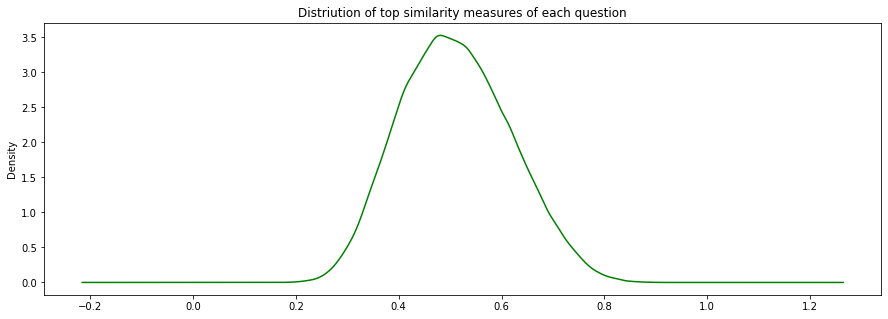

In [ ]:
plt.figure(figsize=(15,8))
distribution = pd.DataFrame(similarities,columns=['similarity'])
distribution.similarity.plot.density(color="green")
plt.title("Distriution of top similarity measures of each question")

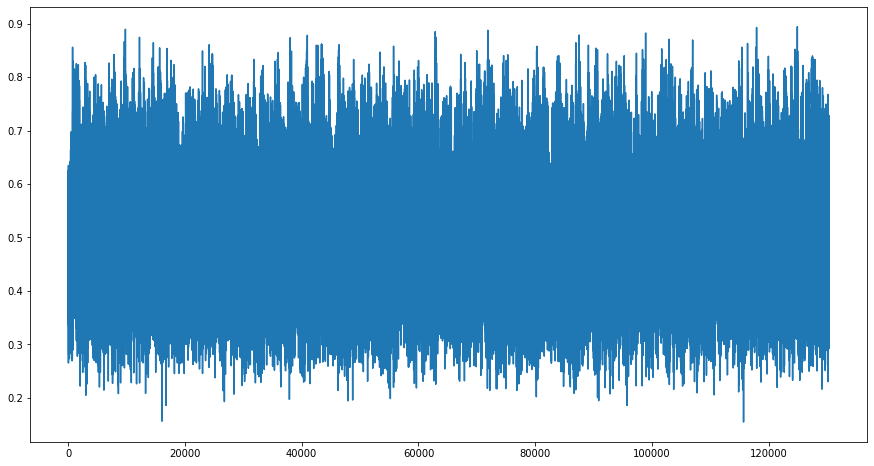

In [ ]:
plt.figure(figsize=(15,8))
distribution.similarity.plot()

In [ ]:
# Maximim similarity value for a question
print(max(similarities))
# Least similarity value for a question
print(min(similarities))
# Mean similarity value for a question
print(sum(similarities)/len(similarities))

0.8944686866507052
0.1545840455889697
0.5105950028018558


In [ ]:
c = 0
for i in range(len(train)):
  if similarities[i] >= 0.35:
    c += 1
  else:
    print(i)
print("\nCount dropped: ",len(train) - c)

In [ ]:
# Example of a dropped question

In [ ]:
temp_df.iloc[54,1]

'Beyonce moved to which town after she left her first elementary school?'

In [ ]:
temp_df.iloc[54,2]

'Beyoncé attended St. Mary\'s Elementary School in Fredericksburg, Texas, where she enrolled in dance classes. Her singing talent was discovered when dance instructor Darlette Johnson began humming a song and she finished it, able to hit the high-pitched notes. Beyoncé\'s interest in music and performing continued after winning a school talent show at age seven, singing John Lennon\'s "Imagine" to beat 15/16-year-olds. In fall of 1990, Beyoncé enrolled in Parker Elementary School, a music magnet school in Houston, where she would perform with the school\'s choir. She also attended the High School for the Performing and Visual Arts and later Alief Elsik High School. Beyoncé was also a member of the choir at St. John\'s United Methodist Church as a soloist for two years.'

In [ ]:
temp_df.iloc[54,3]


'Houston'

In [ ]:
# Heatmap on the correlation between each of the clustered topics
plt.figure(figsize=(200,200))
topic_model.visualize_heatmap()

<Figure size 14400x14400 with 0 Axes>

In [ ]:
# Agglomerative Clustering on the topics clustered based on unique contexts
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_params()

{'calculate_probabilities': True,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7f3b25785590>,
 'hdbscan_model': HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
         approx_min_span_tree=True, cluster_selection_epsilon=0.0,
         cluster_selection_method='eom', core_dist_n_jobs=4,
         gen_min_span_tree=False, leaf_size=40,
         match_reference_implementation=False, memory=Memory(location=None),
         metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
         prediction_data=True),
 'language': 'english',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'top_n_words': 10,
 'umap_model': UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
      dens_var_shift=0.1, densmap=False, disconnection_distance=None,
      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
      local_connectivity=1.0, low_memory

In [ ]:
topic_model.save("/content/drive/MyDrive/AutomatedQuestionGeneration/filtered_topic_model")

In [ ]:
topic_model.load("/content/drive/MyDrive/AutomatedQuestionGeneration/topic_model")

In [ ]:
# TOPIC MODEL FILTERIZER

In [ ]:
train.head(20)

index  ... question_type
0   56be85543aeaaa14008c9063  ...          when
1   56be85543aeaaa14008c9065  ...          what
2   56be85543aeaaa14008c9066  ...          when
3   56bf6b0f3aeaaa14008c9601  ...          what
4   56bf6b0f3aeaaa14008c9602  ...         which
5   56bf6b0f3aeaaa14008c9603  ...          what
6   56bf6b0f3aeaaa14008c9604  ...          what
7   56bf6b0f3aeaaa14008c9605  ...           who
8   56d43c5f2ccc5a1400d830a9  ...          when
9   56d43c5f2ccc5a1400d830aa  ...          what
10  56d43c5f2ccc5a1400d830ab  ...          what
11  56d43c5f2ccc5a1400d830ac  ...          when
12  56d43c5f2ccc5a1400d830ad  ...           how
13  56d43ce42ccc5a1400d830b4  ...          what
14  56d43ce42ccc5a1400d830b5  ...          what
15  56be86cf3aeaaa14008c9076  ...          what
16  56be86cf3aeaaa14008c9078  ...         which
17  56be86cf3aeaaa14008c9079  ...           how
18  56bf6e823aeaaa14008c9627  ...          what
19  56bf6e823aeaaa14008c9629  ...          when

[20 rows x 11 columns]

In [ ]:
train.iloc[0,2]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [ ]:
def topic_filterizer(question):
  if topic_model.find_topics(question)[1][0] >= 0.5:
    return True
  else:
    return False

new_train = train[train["question"].apply(topic_filterizer) == True].head()

In [ ]:
train[train["question"].apply(topic_filterizer) == True]

In [ ]:
c = 0
for i in range(300):
  if topic_model.find_topics(unanswerable_train.iloc[i,1])[1][0] >= 0.3:
    c += 1
  else:
    print(i)
print("Count: ",c)

15
30
55
60
68
69
75
80
125
134
179
193
195
201
236
267
277
Count:  283


In [ ]:
def common_topic(list1, list2):
    result = False
  
    # traverse the 1st list
    for x in list1:
  
        # traverse the 2nd list
        for y in list2:
    
            # if one common
            if x == y:
                result = True
                return result 
                  
    return result

In [ ]:
filtered_train = pd.DataFrame()
c = 0
for i in range(len(train)):
  if common_topic(topic_model.find_topics(train.iloc[i,1])[0],topic_model.find_topics(train.iloc[i,2])[0]):
    filtered_train = filtered_train.append(train.loc[i])[train.columns.to_list()]
    c += 1
  else:
    print(i)

print("\nCount: ",c)

Streaming output truncated to the last 5000 lines.
101379
101380
101396
101480
101535
101552
101553
101555
101558
101559
101572
101573
101577
101611
101616
101629
101631
101632
101634
101636
101637
101639
101640
101658
101663
101666
101675
101681
101687
101735
101771
101773
101776
101777
101781
101782
101783
101790
101791
101810
101813
101815
101817
101818
101822
101824
101825
101830
101831
101841
101853
101854
101857
101865
101866
101872
101873
101874
101876
101878
101881
101884
101885
101886
101900
101903
101911
101912
101917
101918
101923
101928
101931
101932
101938
101940
101949
101950
101953
101954
101956
101957
101964
101972
101980
101988
101994
102002
102003
102004
102009
102015
102027
102032
102035
102036
102039
102057
102062
102065
102077
102078
102080
102089
102100
102101
102107
102109
102112
102117
102123
102150
102151
102162
102163
102164
102165
102166
102170
102172
102176
102177
102185
102186
102187
102188
102192
102193
102194
102195
102196
102197
102202
102205
102206
1022

In [ ]:
filtered_train.to_excel("/content/drive/MyDrive/AutomatedQuestionGeneration/filtered_train.xlsx")

In [ ]:
filtered_train.head()

Empty DataFrame
Columns: []
Index: []

In [ ]:
topic_model.find_topics(train.iloc[i,1])[0]

[214, 76, 349, 342, -1]

In [ ]:
topic_model.find_topics(train.iloc[i,2])[0]

[27, 187, 358, 261, 176]

In [ ]:
train.iloc[999,1]

'What familial role was Albert Grzymała compared to in regards to Frédéric?'

In [ ]:
train.iloc[999,2]

'Two Polish friends in Paris were also to play important roles in Chopin\'s life there. His fellow student at the Warsaw Conservatory, Julian Fontana, had originally tried unsuccessfully to establish himself in England; Albert Grzymała, who in Paris became a wealthy financier and society figure, often acted as Chopin\'s adviser and "gradually began to fill the role of elder brother in [his] life." Fontana was to become, in the words of Michałowski and Samson, Chopin\'s "general factotum and copyist".'

In [ ]:
# Checking if a question returned as not related to any context (since similarity < threshold) is actually an ambiguous question

In [ ]:
# Similarity of the topic most similar to that question
topic_model.find_topics(unanswerable_train.iloc[75,1])

([280, 127, 27, 110, 95],
 [0.28429659243266747,
  0.24898948620547795,
  0.22805656773721722,
  0.22614689466971294,
  0.2251516265330041])

In [ ]:
topic_model.find_topics(unanswerable_train.iloc[75,2])

([325, 44, 202, 121, 272],
 [0.426831726656728,
  0.40685235868771363,
  0.31113241273852527,
  0.30704529642746625,
  0.30701029305889926])

In [ ]:
# Question under analysis
unanswerable_train.iloc[75,1]

'How long did it take to implement riding Phantoms in a believable manner?'

In [ ]:
# Context for that particular question
unanswerable_train.iloc[75,2]

"In four months, Aonuma's team managed to present realistic horseback riding,[l] which Nintendo later revealed to the public with a trailer at Electronic Entertainment Expo 2004. The game was scheduled to be released the next year, and was no longer a follow-up to The Wind Waker; a true sequel to it was released for the Nintendo DS in 2007, in the form of Phantom Hourglass. Miyamoto explained in interviews that the graphical style was chosen to satisfy demand, and that it better fit the theme of an older incarnation of Link. The game runs on a modified The Wind Waker engine."

In [ ]:
# Answer to that question
unanswerable_train.iloc[15,3]

nan